In [3]:
import pandas as pd

In [4]:
df_capital = pd.read_csv('datasets/lacapital.csv')

df_capital.dropna(inplace=True)

df_norm = df_capital.copy()

# Limpieza y normalización de texto 

In [3]:
import unicodedata
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')

stop_words = set(stopwords.words('spanish'))
stop_words_extra = ['año', 'años', 'dos', 'tres', 'si', 'sí']

for word in stop_words_extra:
    stop_words.add(word)

def remove_accents(input_str):
  nfkd_form = unicodedata.normalize('NFKD', input_str)
  return ''.join([c for c in nfkd_form if not unicodedata.combining(c)])

def remove_stopwords(text):
  word_tokens = word_tokenize(text)
  filtered_text = [word for word in word_tokens if word.casefold() not in stop_words]
  return " ".join(filtered_text)

for col in df_capital.columns[:-2]:
    df_norm[col] = df_norm[col].str.lower()
    df_norm[col] = df_norm[col].str.replace('[^\w\s]', '', regex=True)
    df_norm[col] = df_norm[col].apply(remove_stopwords)
    df_norm[col] = df_norm[col].apply(remove_accents)

[nltk_data] Downloading package stopwords to /home/isaias/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/isaias/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Ejercicio 2

In [4]:
df_capital['categoria'].value_counts()

categoria
Ovación                  57
Política                 48
La Ciudad                32
Zoom                     31
Policiales               22
Información General      17
Economía                 16
La Región                16
Mundial de Rugby 2023     8
El Mundo                  6
Educación                 4
Turismo                   4
Negocios                  2
La región                 2
Cristina                  1
Opinión                   1
Julián Montoya            1
Baby Etchecopar           1
Colón                     1
Pepín rodríguez simón     1
Name: count, dtype: int64

In [5]:
categorias = df_norm['categoria'].value_counts()
categorias = categorias[categorias >= 10].index[:5]

In [6]:
categorias_df = list()

for categoria in categorias:
    temp_df = df_norm[df_norm['categoria'] == categoria]
    categorias_df.append(temp_df.sample(22, random_state=1))

In [7]:
x = list()
y = list()

for df in categorias_df:
    x += df['titulo'].tolist()
    y += df['categoria'].tolist()

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report

In [9]:
x_train, x_test, y_train, y_test = \
    train_test_split(x, y, test_size=0.2, random_state=1)

In [10]:
vectorizer = TfidfVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

modelo_LR = LogisticRegression(max_iter=1000)
modelo_LR.fit(x_train_vectorized, y_train)

LogisticRegression(max_iter=1000)

In [11]:
y_pred_LR = modelo_LR.predict(x_test_vectorized)
acc_LR = accuracy_score(y_test, y_pred_LR)
report_LR = classification_report(y_test, y_pred_LR, zero_division=1)

In [12]:
print("Precisión Regresión Logística:", acc_LR)
print("Reporte de clasificación Regresión Logística:\n", report_LR)

Precisión Regresión Logística: 0.5454545454545454
Reporte de clasificación Regresión Logística:
               precision    recall  f1-score   support

      ciudad       1.00      0.40      0.57         5
     ovacion       0.18      1.00      0.31         2
  policiales       1.00      0.44      0.62         9
    politica       0.67      0.67      0.67         3
        zoom       1.00      0.67      0.80         3

    accuracy                           0.55        22
   macro avg       0.77      0.64      0.59        22
weighted avg       0.88      0.55      0.61        22



In [13]:
print(modelo_LR.predict(vectorizer.transform(["en pesos", "pesos de los pumas",
                                              "pesos de los pumas con milei",
                                              "a los tiros en barrio la sexta con perotti un herido de bala, venta drogas y disparos"])))

['ovacion' 'ovacion' 'politica' 'ciudad']


# Ejercicio 3

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

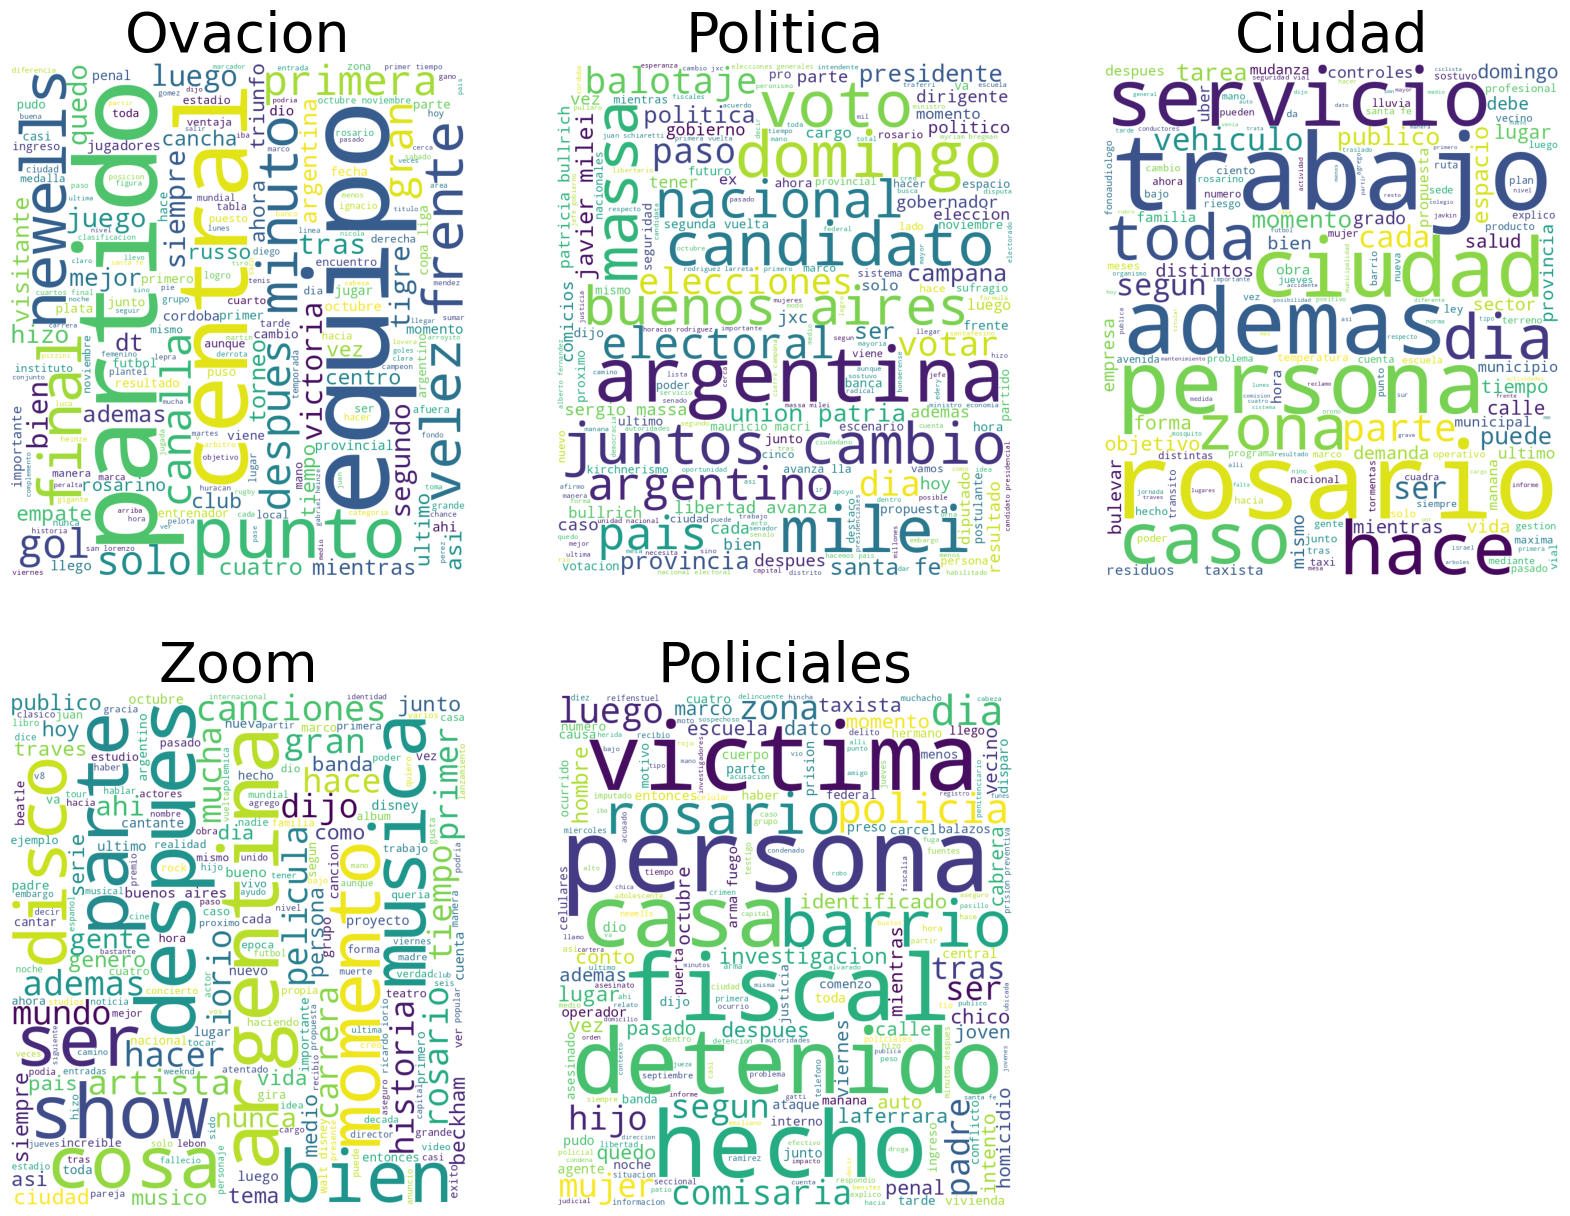

In [15]:
fig = plt.figure(figsize=(20, 15))

for idx, categoria in enumerate(categorias):
    texto = ' '.join(df_norm[df_norm['categoria'] == categoria]['texto'])

    wordcloud = WordCloud(width=800, height=900,
                            background_color='white',
                            stopwords=None,
                            min_font_size=10).generate(texto)


    ax = fig.add_subplot(2, 3, idx + 1)
    ax.imshow(wordcloud)
    plt.title(f'{categoria.capitalize()}', fontsize=40)
    plt.axis("off")


# Ejercicio 4

In [16]:
import torch
from transformers import BertTokenizer, BertModel
from torch.nn.functional import cosine_similarity

tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model     = BertModel.from_pretrained('bert-base-multilingual-cased')

In [5]:
ovacion_norm = df_norm[df_norm['categoria'] == 'ovacion'][:22]
ovacion      = df_capital[df_capital['categoria'] == 'Ovación'][:22]

In [18]:
def crear_embeddings(df, col, n=None):
    
    embeddings_list = list()

    if n == None:
        n = len(df)

    for title in df[col][:n]:
        tokens = tokenizer.tokenize(title)
        token_ids = tokenizer.convert_tokens_to_ids(tokens)
        token_ids = torch.tensor([token_ids])

        with torch.no_grad():
            outputs = model(token_ids)
            embeddings = outputs.last_hidden_state

        embeddings_list.append(embeddings[0])
        
    return embeddings_list

In [19]:
a = crear_embeddings(ovacion_norm, 'titulo')
b = crear_embeddings(ovacion, 'titulo')

In [20]:
similarity = cosine_similarity(a[0].mean(dim=0).unsqueeze(0), a[1].mean(dim=0).unsqueeze(0))
print(f"Similitud entre la primera y segunda oración: {similarity.item()}")

similarity = cosine_similarity(a[0].mean(dim=0).unsqueeze(0), a[2].mean(dim=0).unsqueeze(0))
print(f"Similitud entre la primera y tercera oración: {similarity.item()}")

Similitud entre la primera y segunda oración: 0.6552797555923462
Similitud entre la primera y tercera oración: 0.6436692476272583


In [21]:
titulos_ovacion = []

for ii in ovacion_norm.titulo:
  titulos_ovacion.append(ii)

embeddings_list = []

for sentence in titulos_ovacion:
    tokens = tokenizer.tokenize(sentence)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    token_ids = torch.tensor([token_ids])

    with torch.no_grad():
        outputs = model(token_ids)
        embeddings = outputs.last_hidden_state

    embeddings_list.append(embeddings[0])


similarity = cosine_similarity(embeddings_list[0].mean(dim=0).unsqueeze(0), embeddings_list[6].mean(dim=0).unsqueeze(0))
print(f"Similitud entre la primera y segunda oración: {similarity.item()}")

similarity = cosine_similarity(embeddings_list[0].mean(dim=0).unsqueeze(0), embeddings_list[21].mean(dim=0).unsqueeze(0))
print(f"Similitud entre la primera y tercera oración: {similarity.item()}")

Similitud entre la primera y segunda oración: 0.6539000272750854
Similitud entre la primera y tercera oración: 0.6109477281570435


# Ejercicio 5

In [45]:
noticia = ovacion['texto'][18]

In [46]:
import spacy
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics.pairwise import cosine_similarity

# Cargar el modelo de spaCy
# !python -m spacy download es_core_news_md
nlp = spacy.load('es_core_news_md')

In [47]:
doc = nlp(noticia)

def crear_matriz_de_similitud(doc):
    lemmatized_sentences = list()
    original_sentences   = list()

    for sent in doc.sents:
        lemmatized_sentence = ' '.join(
                                        token.lemma_ for token in sent
                                        if not token.is_stop and 
                                        not token.is_punct)

        if lemmatized_sentence.strip() != '':
            lemmatized_sentences.append(lemmatized_sentence)
            original_sentences.append(str(sent).strip())

    # Procesar las oraciones lematizadas con spaCy para obtener sus vectores
    lemmatized_docs = [nlp(sent) for sent in lemmatized_sentences]

    # Obtenemos una lista con los vectores de cada oración
    sentence_vectors = [sent.vector for sent in lemmatized_docs]

    # Devuelve una matriz de similitud entre las oraciones filtradas
    return cosine_similarity(sentence_vectors)

# Función para generar un resumen extractivo usando PageRank
def summarize(similarity_matrix, num_sentences=5):
    # Crear un grafo a partir de la matriz de similitud
    nx_graph = nx.from_numpy_array(similarity_matrix)
    
    # Aplicar PageRank al grafo
    scores = nx.pagerank(nx_graph)
    
    # Ordenar las oraciones por su puntuación y seleccionar las mejores
    ranked_sentences = sorted(
                            (
                                (scores[i], s) for i, s
                                in enumerate(original_sentences)
                            ),
                            reverse=True)
    
    return ' '.join(ranked_sentences[i][1] for i in range(num_sentences))

In [48]:
resumen = summarize(similarity_matrix, num_sentences=2)

In [49]:
resumen

'Rosario fue elegida para realizar el primer encuentro provincial de ligas sub-12 en el fútbol femenino, que se realizará este sábado a partir de las 10 y se llevará a cabo en el predio de la Asociación Rosarina de Fútbol, exBatallón 121, ubicado en Ayacucho al 5000, muy cerca del Museo del Deporte. La modalidad de la misma será de la siguiente manera: cada equipo contará con un plantel de 18 jugadoras de las categorías 2012.'